In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import random
import matplotlib.pyplot as plt

import gym

from tqdm import tqdm as _tqdm
def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

In [2]:
env = gym.envs.make("MountainCar-v0")
#env = gym.envs.make("CartPole-v0")
#??env.env
# MOUNTAINCAR:
# states are (position,velocity), position from -1.2 to 0.6, velocity from -0.07 to 0.07
# actions are: 0 = push left, 1 = do nothing, 2 = push right

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
class Memory():
    def __init__(self, mem_size = 1000000):
        self.mem_size = mem_size
        self.mem = []
        
    def add(self, transition):
        if len(self.mem) == self.mem_size:
            del self.mem[0]
        self.mem.append(transition)
        
    def sample(self, batch_size):
        if batch_size > len(self.mem):
            self.mem = self.mem * batch_size
        
        samples = random.sample(self.mem, batch_size)
        return samples

In [4]:
# Single hidden layer with 256 hidden nodes DQN
class DQN(nn.Module):
    def __init__(self, num_in, num_out):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(num_in, 30)
        self.fc2 = nn.Linear(30, 30)
        self.fc3 = nn.Linear(30, num_out)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [5]:
def compute_q_val(model, state, action):
    # T tensor, T = [[1,2],[3,4],[5,6]], T[row_indexes,index_for_each_row], T[[0,1,2],[0,0,1]]=[1,3,6]
    return model(torch.tensor(state,dtype=torch.float))[range(0,len(action)),action]
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    # YOUR CODE HERE
    
    # For given (state,action), the target is: reward + discount_factor * max_a{Q(next_state,a)}
    # If next_state is terminal state, then target is just equal to: reward
    Q = model(next_state)
    max_Q_vals, indices = torch.max(Q, 1)
    mask = torch.tensor(1-done, dtype=torch.float)
    target = reward + mask * discount_factor * max_Q_vals
    return target

In [6]:
def calc_reward(s,g):
    q = 0.025
    if abs(s[0] - g) < q:
        r = 0
    else:
        r = -1
    
    return r

In [7]:
def do_train_step(eval_dqn,target_dqn,loss_func,optimizer,minibatch,gamma):
    state,action,reward,next_state,done = zip(*minibatch)
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)
    reward = torch.tensor(reward, dtype=torch.float)
    next_state = torch.tensor(next_state, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)

    #compute the q value
    q_val = compute_q_val(eval_dqn, state, action)

    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(target_dqn, reward, next_state, done, gamma)

    loss = loss_func(q_val,target)
            
    #
    optimizer.zero_grad()
    loss.backward()
#            for param in dqn.parameters():
#                param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return

In [8]:
def perform_test_run(num_episodes_test, given_dqn):
    all_rewards = []

    for epi in range(0,num_episodes_test):
        s = env.reset()

        total_reward = 0
        g = 0.5    
        while True:
            s_g = np.concatenate([s,[g]])
            input_s_g = torch.tensor(s_g,dtype=torch.float)
            action_vals = given_dqn(input_s_g)
            val,ind = torch.max(action_vals, 0)
            action = ind.item()
        
            next_state,reward,done,_ = env.step(action)
            total_reward = total_reward + reward
            if done == True:
                break
            else:
                s = next_state
    
        all_rewards.append(total_reward)
    
    avg_rew = sum(all_rewards)/len(all_rewards)
    num_suc = 0
    for z in all_rewards:
        if z > -200:
            num_suc = num_suc + 1
    
    
    return all_rewards, avg_rew, num_suc

In [9]:
def exec_algorithm():
    # Hyper parameters
    epsilon_start = 1.0
    epsilon_min = 0.05
    epsilon = epsilon_start
    gamma = 1.0
    num_epochs = 1
    num_epi_per_epoch = 500#2000
    batch_size = 64
    NUM_ACTIONS = 3
    
    # Create experience replay buffer
    mem_size = 60000#40000
    mem = Memory(mem_size)
    
    # Create DQNs
    num_in_MC = 2
    num_out_MC = 3
    eval_dqn = DQN(num_in_MC+1, num_out_MC)
    target_dqn = DQN(num_in_MC+1, num_out_MC)
    target_dqn.load_state_dict(eval_dqn.state_dict())
    
    # optimizer parameters
    learning_rate = 1e-3
    loss_func = torch.nn.MSELoss()
    optimizer = optim.Adam(eval_dqn.parameters(), lr=learning_rate)
    
    # Collect statistics
    num_updates = []
    
    ############################################################
    # ALGORITHM PART
    num_updates_done = 0
    all_epi_rew = []

    # the goal
    g0 = 0.5

    for epoch in range(0, num_epochs):
        for epi in tqdm(range(0, num_epi_per_epoch)):
#        for epi in range(0, num_epi_per_epoch):
            s = env.reset()
            real_epi_exp = []
        
            epsilon = epsilon*0.95
            epsilon = max(epsilon_min, epsilon)

            g = g0
        
            # EXPERIENCE
            cur_epi_rew = 0
            while True:
                s_g = np.concatenate([s,[g]])
                # epsilon-greedy policy
                if random.uniform(0,1) < epsilon:
                    action = np.random.randint(NUM_ACTIONS)
                else:
                    input_s_g = torch.tensor(s_g,dtype=torch.float)
                    action_vals = eval_dqn(input_s_g)
                    val,ind = torch.max(action_vals, 0)
                    action = ind.item()

                next_state,reward,done,_ = env.step(action)
                next_state_g = np.concatenate([next_state,[g]])
            
                experience = (s,action,next_state)
                real_epi_exp.append(experience)

                transition = (s_g,action,reward,next_state_g,done)
                mem.add(transition)

                cur_epi_rew = cur_epi_rew + reward

                # Train network
                # Sample minimatch

                if len(mem.mem) > batch_size:
                    minibatch = mem.sample(batch_size)
                    do_train_step(eval_dqn,target_dqn,loss_func,optimizer,minibatch,gamma)
                    num_updates_done = num_updates_done + 1

                if done == True:
                    # Update target network
                    target_dqn.load_state_dict(eval_dqn.state_dict())
                    break
                else:
                    s = next_state
            all_epi_rew.append(cur_epi_rew)
            num_updates.append(num_updates_done)
        
            # Add to experience replay
            _,_,all_ns = zip(*real_epi_exp)
            num_goals = 4
            for n in range(0,num_goals):
                g_new = all_ns[random.randint(0,len(real_epi_exp)-1)]
                g_new = g_new[0]
                for t in range(0, len(real_epi_exp)): # =(goal_index+1)-1
                    s,a,next_s = real_epi_exp[t]
                    s_g_new = np.concatenate([s,[g_new]])
                    next_s_g_new = np.concatenate([next_s,[g_new]])
                    r_new = calc_reward(next_s,g_new)
                    if r_new != -1:
                        done = True
                    else:
                        done = False
                    transition = (s_g_new,a,r_new,next_s_g_new,done)
                    mem.add(transition)
                    if done == True:
                        break

    ############################################################
    return eval_dqn,num_updates,all_epi_rew

In [10]:
# No need to set seeds
# seed = 123
# random.seed(seed)
# torch.manual_seed(seed)
# env.seed(seed)

# Train "num_models_test" a new model, and check the performance
num_models_test = 30

models_epi_rewards = []
models_num_updates = []

for i in range(0, num_models_test):
    # Train a new model, collect test statistics
    ith_model,ith_model_num_updates,ith_model_all_epi_rew = exec_algorithm()

    # Save model
    ith_model_filename = "dqn_model_" + str(i) + "_HER.pth"
    torch.save(ith_model.state_dict(), ith_model_filename)
    
    # Collect statistics
    models_epi_rewards.append(ith_model_all_epi_rew)
    models_num_updates.append(ith_model_num_updates)



100%|██████████| 500/500 [06:24<00:00,  1.30it/s]


In [11]:
#print((models_epi_rewards,models_num_updates))

import pickle
HER_full_info_filename = "HER_full_info_gstrat_episode_mult_4"

HER_full_info = (models_epi_rewards,models_num_updates)
pickle.dump(HER_full_info, open(HER_full_info_filename, 'wb'))

loaded_HER_full_info = pickle.load(open(HER_full_info_filename, 'rb'))
loaded_A,loaded_B = loaded_HER_full_info
print(np.sum(np.array(models_num_updates) - np.array(loaded_B)))

0


<ErrorbarContainer object of 3 artists>

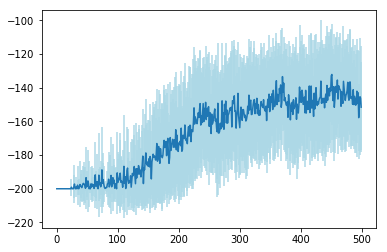

In [12]:
models_mean_epi_reward = np.mean(np.array(models_epi_rewards), axis=0)
models_epi_reward_std = np.std(np.array(models_epi_rewards), axis=0)
evaluated_num_updates = np.mean(np.array(models_num_updates), axis=0)


t = np.arange(0,500)
plt.errorbar(t,models_mean_epi_reward,models_epi_reward_std,ecolor="lightblue")

<ErrorbarContainer object of 3 artists>

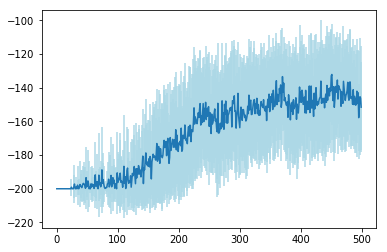

In [13]:
import pickle
HER_plot_info_filename = "HER_plot_info_gstrat_episode_mult_4"

HER_plot_info = (models_mean_epi_reward,models_epi_reward_std)
pickle.dump(HER_plot_info, open(HER_plot_info_filename, 'wb'))

loaded_HER_plot_info = pickle.load(open(HER_plot_info_filename, 'rb'))
loaded_HER_models_mean_epi_reward,loaded_HER_models_epi_reward_std = loaded_HER_plot_info

t = np.arange(0,500)
plt.errorbar(t,loaded_HER_models_mean_epi_reward,loaded_HER_models_epi_reward_std,ecolor="lightblue")

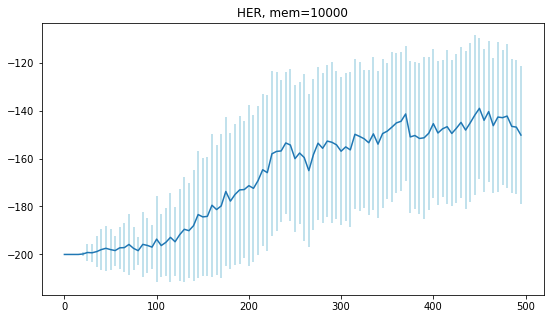

In [14]:
dist = 5
tot_num_points = int(len(models_mean_epi_reward)/dist)
Q_means = []
Q_stds = []

for k in range(0, tot_num_points):
    avg_kth_mean = (1.0/dist) * np.sum(models_mean_epi_reward[k*dist:(k+1)*dist])
    Q_means.append(avg_kth_mean)
    avg_kth_std = (1.0/dist) * np.sum(models_epi_reward_std[k*dist:(k+1)*dist])
    Q_stds.append(avg_kth_std)

t = np.arange(0,500,dist)

plt.figure(figsize=(9,5))
plt.errorbar(t,Q_means,Q_stds,ecolor="lightblue")
plt.title("HER, mem=10000")
plt.show()

In [15]:
######################   END